# 非线性偏微分方程

0. [绘图辅助函数](#Plot)
1. [伯格斯方程(Burgers Equation)](#BurgersEquation)
2. [Allen-Cahn Equation)](#AllenCahnEquation)
3. [Schrodinger Equation](#SchrodingerEquation)
4. [KdV Equation](#KdVEquation)
5. [Navier-Stokes Equation](#NavierStokesEquation)


## 运行版本

In [1]:
import sys

sys.version

'3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import tensorflow

tensorflow.__version__

'2.6.0'

In [3]:
import torch

torch.__version__

'1.10.1'

In [4]:
# !python -m deepxde.backend.set_default_backend pytorch

In [5]:
import deepxde

deepxde.__version__

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



'1.1.3'

<a id="Plot"></a>
## 绘图辅助函数

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


def plot_loss_history(loss_history, figsize=(10, 8)):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=figsize)
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    

def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state, figsize=(10, 6)):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=figsize)
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=tuple([i*2 for i in figsize]))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()


<a id="BurgersEquation"></a>
## 1. Burgers equation

伯格斯方程(Burgers equation)是一个模拟冲击波的传播和反射的非线性偏微分方程。具体表达式为$$\Large u_t + u u_x=\nu u_{xx}$$
Burgers 方程是一个基本的偏微分方程，出现在应用数学的各个领域，例如流体力学、非线性声学、气体动力学和交通流。该方程由Harry Bateman于 1915年首次引入，后来由Johannes Martinus Burgers于 1948 年进行了研究。

参考：

https://en.wikipedia.org/wiki/Burgers%27_equation

http://www.bcamath.org/projects/NUMERIWAVES/Burgers_Equation_M_Landajuela.pdf

https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/burgers.pdf

### 问题设置

我们将求解一个 Burgers 方程：

$$\large \frac{∂u}{∂t}+u\frac{∂u}{∂x}=\nu \frac{∂^2u}{∂x^2},x∈[−1,1],t∈[0,1].$$ 

具有狄利克雷边界条件和初始条件

$u(−1,t)=u(1,t)=0,u(x,0)=−sin(πx).$ 

参考解决方案在[这里](https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Burgers.npz)。

代码来源：https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html

### 执行

本描述逐步介绍了上述 Burgers 方程的求解器的实现。

首先，导入 DeepXDE 和 TensorFlow ( `tf`) 模块：

In [2]:
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term




我们首先定义一个计算几何和时域。我们可以使用内置类`Interval`，并且我们使用以下方式`TimeDomain`组合两个域`GeometryXTime`

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

接下来，我们表达 Burgers 方程的 PDE 残差：

In [4]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

`pde`的第一个参数是二维向量，其中第一个分量 ( `x[:,0]`) 是xx-坐标，第二个组件 ( `x[:,1]`) 是tt-协调。第二个参数是网络输出，即解u(x,t)u(x,t), 但这里我们使用`y`作为变量的名称。

接下来，我们考虑边界/初始条件。`on_boundary`这里选择使用计算域的整个边界作为边界条件。我们在DeepXDE 的功能中包含`geomtime`了上面创建的空间、时间几何和`on_boundary`作为 BC 。`DirichletBC`我们还定义`IC`了汉堡方程的初始条件，我们使用计算域、初始函数并`on_initial`指定 IC。


In [5]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

现在，我们已经指定了几何、PDE 残差和边界/初始条件。然后我们将`TimePDE`问题定义为

In [6]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2540, num_boundary=80, num_initial=160)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


数字 2540 是在域内采样的训练残差点数，数字 80 是在边界上采样的训练点数。我们还包括初始条件的 160 个初始残差点。

接下来，我们选择网络。在这里，我们使用深度为 4（即 3 个隐藏层）和宽度为 20 的全连接神经网络：

In [7]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

现在，我们有 PDE 问题和网络。我们构建一个`Model`并选择优化器和学习率：

In [8]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.056687 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.304350 s



然后我们训练模型进行 15000 次迭代：

In [9]:
losshistory, train_state = model.train(epochs=15000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.01e-02, 6.34e-03, 5.28e-01]    [1.01e-02, 6.34e-03, 5.28e-01]    []  
1000      [3.68e-02, 2.53e-04, 5.10e-02]    [3.68e-02, 2.53e-04, 5.10e-02]    []  
2000      [2.05e-02, 8.28e-05, 2.70e-02]    [2.05e-02, 8.28e-05, 2.70e-02]    []  
3000      [7.48e-03, 2.42e-05, 8.03e-03]    [7.48e-03, 2.42e-05, 8.03e-03]    []  
4000      [5.59e-03, 1.78e-05, 4.98e-03]    [5.59e-03, 1.78e-05, 4.98e-03]    []  
5000      [2.81e-03, 7.66e-06, 1.33e-03]    [2.81e-03, 7.66e-06, 1.33e-03]    []  
6000      [1.95e-03, 3.23e-06, 7.55e-04]    [1.95e-03, 3.23e-06, 7.55e-04]    []  
7000      [1.48e-03, 1.75e-06, 5.33e-04]    [1.48e-03, 1.75e-06, 5.33e-04]    []  
8000      [1.12e-03, 1.16e-06, 3.69e-04]    [1.12e-03, 1.16e-06, 3.69e-04]    []  
9000      [2.09e-03, 7.12e-06, 2.66e-04]    [2.09e-03, 7.12e-06, 2.66e-04]    []  
10000     [6.50e-04, 6.26e-07, 1.94

在我们使用 Adam 训练网络之后，我们继续使用 L-BFGS 训练网络以实现更小的损失：

In [10]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.202923 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [9.91e-04, 2.64e-06, 1.00e-04]    [9.91e-04, 2.64e-06, 1.00e-04]    []  
16000     [9.74e-05, 5.05e-07, 2.96e-05]                                          
17000     [4.68e-05, 2.41e-07, 8.77e-06]                                          
18000     [2.12e-05, 6.67e-08, 4.29e-06]                                          
19000     [1.14e-05, 4.32e-08, 1.48e-06]                                          
20000     [7.42e-06, 3.85e-08, 1.14e-06]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000008
  Number of iterations: 4987
  Number of functions evaluations: 5363
20363     [6.84e-06, 3.01e-08, 8.66e-07]    [6.84e-06, 3.01e-08, 8.66e-07]    []  

Best model at step 20363:
  train loss: 7.74e-06
  t

plot

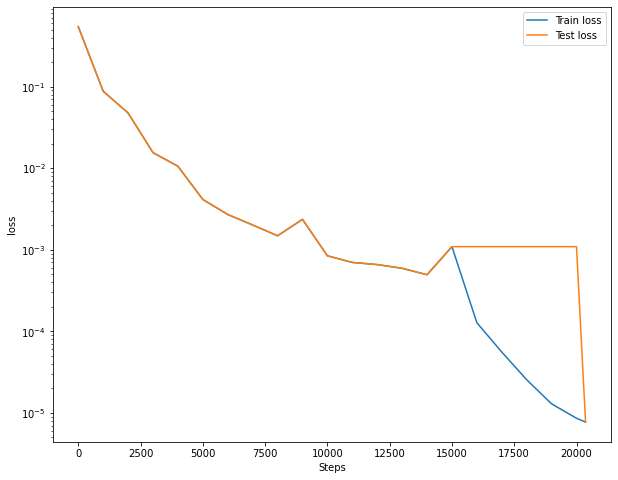

In [11]:
plot_loss_history(losshistory)

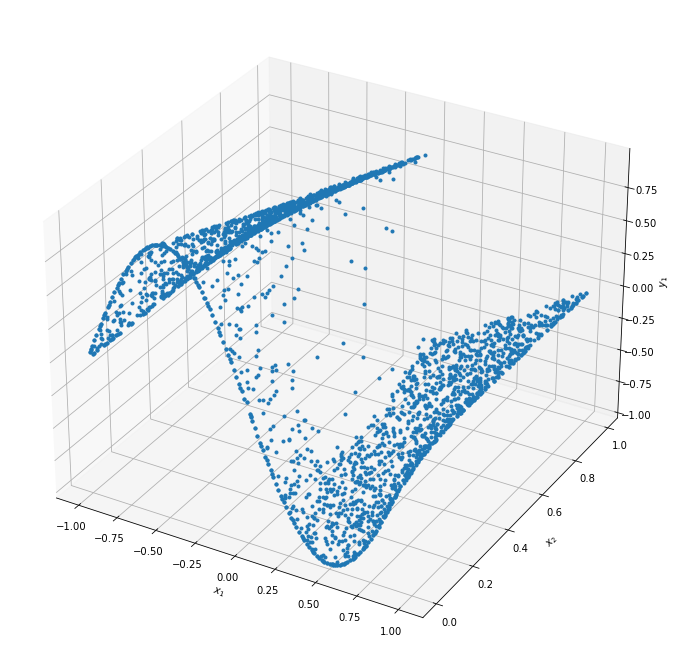

In [12]:
plot_best_state(train_state)

predict

In [13]:
def gen_testdata():
    data = np.load("dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


X, y_true = gen_testdata()

In [14]:
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
# np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.005000037
L2 relative error: 0.011202712877472312


<a id="AllenCahnEquation"></a>

## Allen-Cahn equation

Allen-Cahn方程是一类非齐次半线性泊松方程。1979年，为了描述晶体中反相位边界运动，Allen和Cahn引入了Allen-Cahn方程。该方程是材料科学中描述流体动力学问题和反应扩散问题的一类重要方程，且在描述生物种群的竞争与排斥现象、河床的迁移过程等许多扩散现象的研究中也提出同样的数学模型。对Allen-Cahn方程的研究是在上个世纪七十年代以后开始的。

Allen-Cahn方程广泛运用于处理各种问题，例如图像分析，平均曲率-流量，和晶体生长。人们在对Allen-Cahn方程进行数值计算时，采用算子分裂算法进行方程的求解计算，能够将一个复杂的算子分裂成几个较简单的子算子之积，从而把一个复杂的数学物理问题分裂成一些简单的问题来求解。它既适用于典型的双曲型方程和抛物型方程，也适用于更为复杂的方程的初边值问题，且分裂后的方程更加容易求解、格式灵活、稳定性好。


##### 示例3(Allen Cahn方程)

本例旨在强调所提出的离散时间模型处理控制偏微分方程中不同类型非线性的能力。为此，让我们考虑[Allen-Cahn equation](https://en.wikipedia.org/wiki/Allen–Cahn_equation) 和周期边界条件。
$$
\begin{align}
& \large u_t - D u_{xx} + 5u^3 - 5u = 0, x \in [-1,1], t \in [0,1], \\
& \large u(x,0) = x^2 cos(\pi x), \\
(论文1) &D = 0.0001     \\
& \large u(-1,t) = u(1,t), \\
& \large u_x(-1,t) = u_x(1,t). \\
(论文2) &D = 0.001     \\
& \large u(-1,t) = u(1,t) = 1, \\
\end{align}
$$
Allen-Cahn方程是反应扩散系统领域的一个著名方程。它描述了多组分合金系统中的相分离过程，包括有序-无序转变。对于Allen-Cahn方程，非线性算子由下式给出：
$$
\large \cal N[u^{n+c_j}] = - D u^{n+c_j}_{xx} + 5(u^{n+c_j})^3 - 5u^{n+c_j},
$$
通过最小化误差平方和，可以学习神经网络的共享参数
$$
\begin{align}
 SSE  &= SSE_n + SSE_b,\\
SSE_n &= \sum^{q+1}_{j=1} \sum^{N_n}_{i=1} |u^n_j(x^{n,i}) - u^{n,i}|^2,\\
\end{align}
$$

$$
\begin{equation}
\begin{aligned}
SSE_b &= \sum^q_{i=1} |u^{n+c_i}(-1) - u^{n+c_i}(1)|^2 + |u^{n+1}(-1) - u^{n+1}(1)|^2 \\
        & + \sum^q_{i=1} |u^{n+c_i}(-1) - u^{n+c_i}(1)|^2 + |u^{n+1}(-1) - u^{n+1}(1)|^2 ,\\
\end{aligned}
\end{equation}
$$

这里，$\{x^{n,i}, u^{n,i}\}^{N_n}_{i=1}$ 对应于时刻 $t_n$ 的数据。



下图总结了我们使用上述损失函数对网络进行训练后的预测。

![img](https://maziarraissi.github.io/assets/img/AC.png)

> *Allen-Cahn方程*：**顶部**：初始训练快照在t=0.1时的位置以及最终预测快照在t=0.9时的位置。**底部**：顶部面板中白色垂直线所示快照处的初始训练数据和最终预测。


论文1: https://arxiv.org/abs/1711.10561 中 Allen Cahn方程 $u_{xx}$的系数是 0.0001。上图是论文1的结果。

论文2: https://arxiv.org/abs/2111.02801 中 Allen Cahn方程 $u_{xx}$系数是 0.001。下面的代码和数据来自论文2。

代码参考

https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/Allen_Cahn.py


https://github.com/maziarraissi/PINNs/blob/master/main/discrete_time_inference%20(AC)/AC.py

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch
Implementation of Allen-Cahn equation example in paper https://arxiv.org/abs/2111.02801.
"""
import deepxde as dde
import numpy as np
from scipy.io import loadmat
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
d = 0.001   # 论文2  𝑢_{xx} 的系数是 0.001

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - d * dy_xx - 5 * (y - y**3)


data = dde.data.TimePDE(geomtime, pde, [], num_domain=8000, num_boundary=400, num_initial=800)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+8002=8002. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+802=802. 
  warnings.warn("The balance properties of Sobol' points require "


In [4]:
# Hard restraints on initial + boundary conditions
# Backend tensorflow.compat.v1 or tensorflow
def output_transform(x, y):
    return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

# Backend pytorch
# def output_transform(x, y):
#     return x[:, 0:1]**2 * torch.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y



net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

In [5]:
model.compile("adam", lr=1e-3)
model.train(epochs=40000)

Compiling model...
Building feed-forward neural network...
'build' took 0.076939 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.863028 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [6.63e-01]    [6.63e-01]    []  
1000      [7.49e-02]    [7.49e-02]    []  
2000      [1.43e-02]    [1.43e-02]    []  
3000      [1.10e-02]    [1.10e-02]    []  
4000      [9.83e-03]    [9.83e-03]    []  
5000      [8.92e-03]    [8.92e-03]    []  
6000      [8.64e-03]    [8.64e-03]    []  
7000      [7.63e-03]    [7.63e-03]    []  
8000      [7.16e-03]    [7.16e-03]    []  
9000      [6.75e-03]    [6.75e-03]    []  
10000     [6.42e-03]    [6.42e-03]    []  
11000     [6.19e-03]    [6.19e-03]    []  
12000     [5.97e-03]    [5.97e-03]    []  
13000     [5.82e-03]    [5.82e-03]    []  
14000     [5.70e-03]    [5.70e-03]    []  
15000     [6.27e-03]    [6.27e-03]    []  
16000     [5.55e-03]    [5.55e-03]    []  
17000     [5.41e-03]    [5.41e-03]    []  
18000     [5.30e-03]    [5.30e-03]    []  
19000     [5.13e-03]    [5.13e-03]    []  
20000     [5.02e-0

(<deepxde.model.LossHistory at 0x2b06e994bb0>,
 <deepxde.model.TrainState at 0x2b06e99aee0>)

In [6]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.409839 s

Training model...

Step      Train loss    Test loss     Test metric
40000     [4.30e-03]    [4.30e-03]    []  
41000     [5.80e-04]                      
42000     [2.09e-04]                      
43000     [1.09e-04]                      
44000     [6.63e-05]                      
45000     [4.13e-05]                      
46000     [3.10e-05]                      
47000     [2.35e-05]                      
48000     [1.88e-05]                      
49000     [1.54e-05]                      
50000     [1.30e-05]                      
51000     [1.07e-05]                      
52000     [9.20e-06]                      
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000009
  Number of iterations: 11687
  Number of functions evaluations: 12313
52313     [8.93e-06]    [8.93e-06]    []  

Best model at step 52313:
  train loss: 8.93e-06
  test loss: 8.93e-0

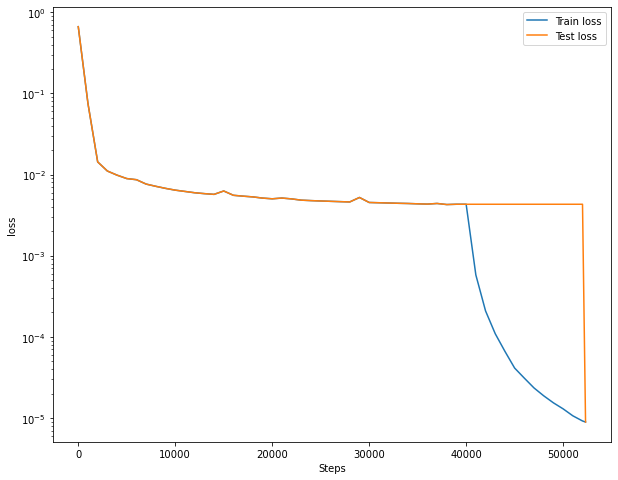

In [7]:
plot_loss_history(losshistory)

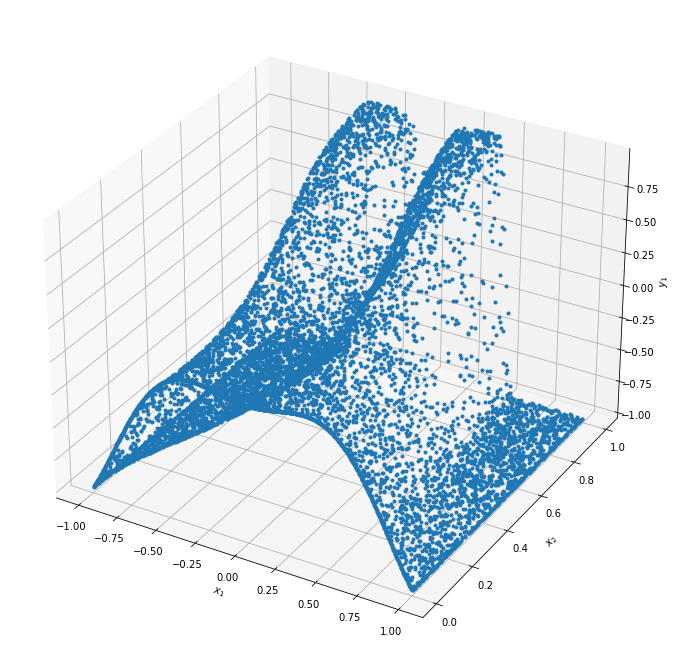

In [8]:
plot_best_state(train_state)

In [9]:
def gen_testdata():
    data = loadmat("dataset/Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y


X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
# np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.0021852897
L2 relative error: 0.01905140591506532


<a id="SchrodingerEquation"></a>

## Schrodinger equation

薛定谔方程（Schrödinger equation），又称薛定谔波动方程（Schrodinger wave equation），是由奥地利物理学家薛定谔提出的量子力学中的一个基本方程，也是量子力学的一个基本假定。

它是将物质波的概念和波动方程相结合建立的二阶偏微分方程，可描述微观粒子的运动，每个微观系统都有一个相应的薛定谔方程式，通过解方程可得到波函数的具体形式以及对应的能量，从而了解微观系统的性质。在量子力学中，粒子以概率的方式出现，具有不确定性，宏观尺度下失效可忽略不计。

------
薛定谔方程揭露了微观世界中物质运动的基本规律，其意义相当于牛顿运动方程对于经典力学体系。由于对于具有波粒二象性的体系无法用实验证明，因此它是量子力学的一个基本假定，但是它经历住了90多年的考验。薛定谔本人也被界内尊称为物理学家的物理学家。

在量子力学中，薛定谔方程（Schrödinger equation）是描述物理系统的量子态随时间演化的偏微分方程，为量子力学的基础方程之一，其以发表者奥地利物理学家埃尔温·薛定谔而命名。关于量子态与薛定谔方程的概念涵盖于基础量子力学假说里，无法从其它任何原理推导而出。

在经典力学里，人们使用牛顿第二定律描述物体运动。而在量子力学里，类似的运动方程为薛定谔方程。薛定谔方程的解完备地描述物理系统里，微观尺寸粒子的量子行为；这包括分子系统、原子系统、亚原子系统；另外，薛定谔方程的解还可完备地描述宏观系统，可能乃至整个宇宙。

薛定谔方程可以分为“含时薛定谔方程”与“不含时薛定谔方程”两种。含时薛定谔方程与时间有关，描述量子系统的波函数怎样随着时间而演化。不含时薛定谔方程则与时间无关，描述了定态量子系统的物理性质；该方程的解就是定态量子系统的波函数。量子事件发生的概率可以用波函数来计算，其概率幅的绝对值平方就是量子事件发生的概率密度。

薛定谔方程所属的波动力学可以数学变换为维尔纳·海森堡的矩阵力学，或理察·费曼的路径积分表述。薛定谔方程是个非相对论性方程，不适用于相对论性理论；对于相对论性微观系统，必须改使用狄拉克方程或克莱因-戈尔登方程等。

#### 含时薛定谔方程

含时薛定谔方程描述物理系统随时间演化，其最广义形式为：
$$
\large \hat{H} \Psi = i\hbar \frac{\partial}{\partial t}\Psi;
$$
其中，$\large\hat{H}$ 是表征波函数总能量的哈密顿算符，$\large\Psi$ 是物理系统的波函数，$\large i$ 是虚数单位，$\large\hbar$ 是约化普朗克常数，$\large\frac{\partial}{\partial t}$ 是对于时间 $\large t$ 的偏微分。

图为波函数在某一时刻的实部，横轴是位置坐标轴。该波函数描述粒子移动于自由空间的物理行为。该波函数满足势函数$\large V$为零的薛定谔方程。点击[这里](https://zh.wikipedia.org/wiki/File:Wave_packet_(no_dispersion).gif)即可观看这波函数的实部随时间演化的动画。

在三维空间里，移动于位势 $\large V(\mathbf{r} ,t)$的单独粒子，其含时薛定谔方程可以更具体地表示为：
$$
\large -\frac{\hbar^2}{2m} \nabla^2 \Psi(\mathbf{r},t) + V(\mathbf{r} ,t) \Psi(\mathbf{r},t) = i\hbar \frac{\partial}{\partial t}\Psi(\mathbf{r},t);
$$
其中，$\large m$ 是质量，$\large \Psi (\mathbf {r} ,t)$ 是参数为位置 $\large\mathbf {r}$、时间 $\large t$ 的波函数，$\large\nabla^2$ 是拉普拉斯算符。

术语“薛定谔方程”可以指广义形式的薛定谔方程，也可指具体形式的薛定谔方程。广义形式的薛定谔方程名如其实，可以应用于广泛量子力学领域，表达从狄拉克方程到量子场论的各种方程，只要将哈密顿算符的各种复杂表达式代入即可。通常，具体形式的薛定谔方程所描述的系统是实际系统的简化近似模型，这是为了要避开不必要的复杂数学运算。对于大多数案例，所得到的结果相当准确；但是对于相对论性案例，结果则并不令人满意。对于更详尽的细节，请参阅相对论性量子力学。

#### 不含时薛定谔方程

若 $\large \Psi(\mathbf{r},t)=\psi(\mathbf{r})\varphi(t), 其中\varphi(t) = e^{\frac{-iEt}{\hbar}}$，则 $\large i\hbar\frac{1}{\varphi} \frac{d \varphi}{d t} = -\frac{\hbar^2}{2m} \frac{1}{\psi} \nabla^2 \psi + V = E$，则含时薛定谔方程可转化为不含时薛定谔方程：
$$
\large -\frac{\hbar^2}{2m} \nabla^2 \psi(\mathbf{r}) + V(\mathbf{r}) \psi(\mathbf{r}) = E \psi(\mathbf{r});
$$
不含时薛定谔方程也可写为
$$
\large {\hat {H}} \psi = E \psi;
$$
其中，$\large {\hat {H}}=-{\frac {\hbar ^{2}}{2m}}\nabla ^{2}+V(\mathbf {r} )$ 是哈密顿算符。

#### 相对论性薛定谔方程

薛定谔方程并没有涉及到相对论效应。对于伽利略变换，薛定谔方程的形式不变。 对于洛伦兹变换，薛定谔方程的形式会改变。为了要涵盖相对论效应，必须将薛定谔方程加以延伸。试想能量-动量关系式，
$$
\large E^2 = p^2c^2 + m^2c^4;
$$


其中，$c$ 是光速，$m$ 是静止质量。

将这关系式内的能量与动量改为其对应的算符，将整个关系式作用于波函数，可以得到
$$
\large - \hbar^2\frac{\partial^2}{\partial t^2}\Psi =  - \hbar^2c^2\nabla^2 \Psi + m^2c^4 \Psi;
$$
稍加编排，可以得到克莱因-戈尔登方程：
$$
\large (\Box^2 + \mu^2) \psi = 0;
$$
其中，$\large \Box ^{2}={\frac {1}{c^{2}}}{\frac {\partial ^{2}}{\partial t^{2}}}-\nabla ^{2}$  是达朗贝尔算符，$\large\ mu ={\frac {mc}{\hbar }}$ 。

对于洛伦兹变换，这方程的形式不会改变，是个洛伦兹不变式。

##### 示例2(薛定谔方程)

本例旨在强调我们的方法处理周期边界条件、复值解以及控制偏微分方程中不同类型非线性的能力。**非线性薛定谔方程**([nonlinear Schrödinger equation](https://en.wikipedia.org/wiki/Nonlinear_Schrödinger_equation))和周期边界条件由下式给出：
$$
\begin{align}
& \large ih_t + 0.5h_{xx} + |h|^2h = 0, x \in [-5,5], t \in [0,\pi/2],\\
& \large h(0,x) = 2 sech(x),\\
& \large h(t,-5) = h(t,5),\\
& \large h_x(t,-5) = h_x(t,5),\\
\end{align}
$$
其中 $h(t,x)$ 是复数解。让我们定义 $f(t,x)$ 为
$$
\large f := ih_t + 0.5h_{xx} + |h|^2h ,
$$

然后在 $h(t,x)$ 上放置一个复值神经网络(complex-valued neural network)。事实上，如果 $u$ 表示 $h$ 的实部，$v$ 是虚部，我们在 $h(t,x) = [u(t,x)\ \ \ \ \ \ v(t,x)]$上放置一个多输出神经网络。这将产生复数（多输出）物理信息神经网络 $f(t,x)$。通过最小化均方误差损失，可以学习神经网络 $h(t,x)$ 和 $f(t,x)$ 的共享参数
$$
\begin{align}
& MSE = MSE_0 + MSE_b + MSF_f,\\
& MSE_0 = \frac 1 {N_0} \sum^{N_0}_{i=1} |h(0,x^i_0) - h^i_0|^2,\\
& MSE_b = \frac 1 {N_b} \sum^{N_b}_{i=1} \left ( |h^i(t^i_b,-5) - h^i(t^i_b,5)|^2 + 
                              |h^i_x(t^i_b,-5) - h^i_x(t^i_b,5)|^2 \right ),\\
& MSE_f = \frac 1 {N_f} \sum^{N_f}_{i=1} |f(t^i_f, x^i_f)|^2.\\
\end{align}
$$
这里，$\{ {x^i_0, h^i_0} \}^{N_0}_{i=1}$ 表示初始数据，$\{ {t^i_b} \}^{N_b}_{i=1}$ 对应于边界上的配置点，$\{{t^i_f,x^i_f}\}^{N_f}_{i=1}$ 表示 $f(t,x)$ 上的配置点。因此，$MSE_0$ 对应于初始数据的损失， $MSE_b$ 强制执行周期性边界条件， $MSE_f$ 惩罚配置点上不满足的薛定谔方程。
下图总结了我们的实验结果。

![img](https://maziarraissi.github.io/assets/img/NLS.png)

> *Shrödinger方程*：**顶部**：预测解以及初始和边界训练数据。此外，我们使用20000个搭配点，这些搭配点是使用拉丁超立方体采样策略生成的。**底部**：与顶部面板中垂直虚线描绘的三个时间快照对应的预测和精确解的比较。

代码参考 

https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/Schrodinger.ipynb

### 问题设置
  
我们将要解决的非线性薛定谔方程为：
$$\large i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$$  
  
周期性的边界条件：  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
初值条件：
$h(0,x) = 2 sech(x)$



Deepxde 只使用实数，因此我们需要显式地拆分复 PDE 的实部和虚部。

In place of the single residual 代替单一函数  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  

we get the two (real valued) residuals 我们得到两个(实值)函数  
$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  

where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.
其中 u (x，t)和 v (x，t)分别表示 h 的实部和虚部。

In [2]:
import numpy as np
import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [3]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [4]:
# The "physics-informed" part of the loss

def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [5]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u = dde.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [6]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

Adam optimization.  

In [7]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.083824 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 4.487947 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.05e-01, 2.28e-02, 4.82e-01, 1.68e-06, 2.46e+00, 1.25e-04, 9.41e-01, 3.16e-01]    [1.05e-01, 2.28e-02, 4.82e-01, 1.68e-06, 2.46e+00, 1.25e-04, 9.41e-01, 3.16e-01]    []  
1000      [1.28e-02, 1.54e-02, 1.73e-03, 2.23e-04, 8.20e-05, 7.06e-06, 2.14e-02, 2.73e-03]    [1.28e-02, 1.54e-02, 1.73e-03, 2.23e-04, 8.20e-05, 7.06e-06, 2.14e-02, 2.73e-03]    []  
2000      [8.42e-03, 1.02e-02, 1.14e-04, 7.79e-05, 4.35e-05, 6.99e-06, 1.43e-02, 7.33e-04]    [8.42e-03, 1.02e-02, 1.14e-04, 7.79e-05, 4.35e-05, 6.99e-06, 1.43e-02, 7.33e-04]    []  
3000      [5.75e-03, 7.35e-03, 4.99e-06, 1.98e-05, 7.71e-06, 8.84e-06, 8.38e-03, 1.58e-04]    [5.75e-03, 7.35e-03, 4.99e-06, 1.98e-05, 7.71e-06, 8.84e-06, 8.38e-03, 1.58e-04]    []  
4000  

(<deepxde.model.LossHistory at 0x289bbe15820>,
 <deepxde.model.TrainState at 0x289bbe15130>)

L-BFGS optimization.

In [8]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.566849 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [4.35e-04, 5.47e-04, 3.89e-05, 3.18e-06, 3.02e-05, 2.56e-06, 3.95e-04, 1.21e-05]    [4.35e-04, 5.47e-04, 3.89e-05, 3.18e-06, 3.02e-05, 2.56e-06, 3.95e-04, 1.21e-05]    []  
11000     [2.69e-05, 2.81e-05, 6.89e-08, 9.20e-08, 4.13e-07, 2.65e-07, 5.35e-06, 3.95e-07]                                                                                            
12000     [7.87e-06, 7.69e-06, 6.42e-08, 1.36e-07, 9.50e-08, 1.26e-07, 3.72e-06, 1.68e-07]                                                                                            
13000     [3.64e-06, 3.79e-06, 2.52e-08, 7.34e-08, 1.57e-08, 2.64e-08, 2.89e-06, 1.73e-07]                                                                                            
14000     [2.

最终结果。  
参考解决方案和进一步的信息可以在来自 Karniadakis，Perdikaris 的 Raissi 的[论文](https://arxiv.org/abs/1711.10561)中找到。  
测试数据可以在[这里](https://github.com/maziarraissi/PINNs/blob/master/main/Data/NLS.mat)得到。

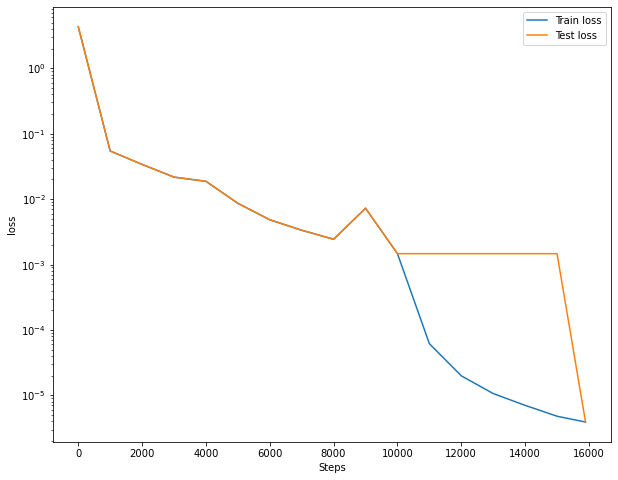

In [9]:
plot_loss_history(losshistory)

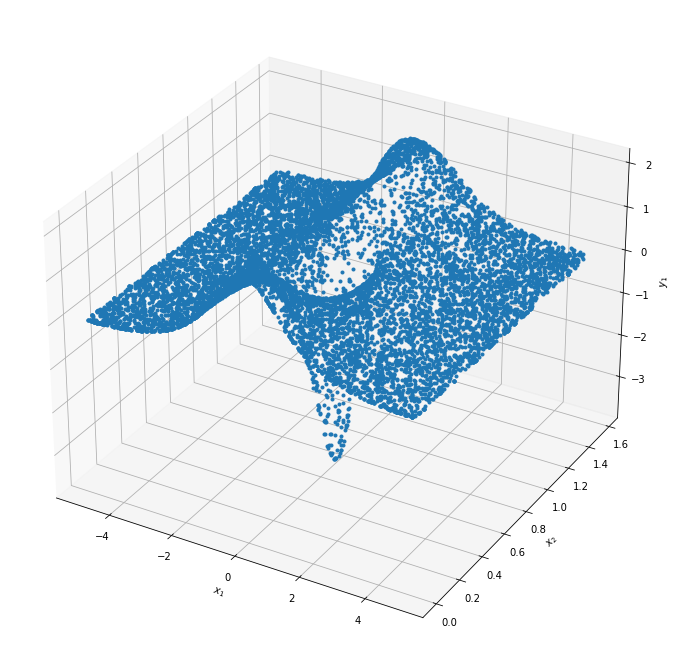

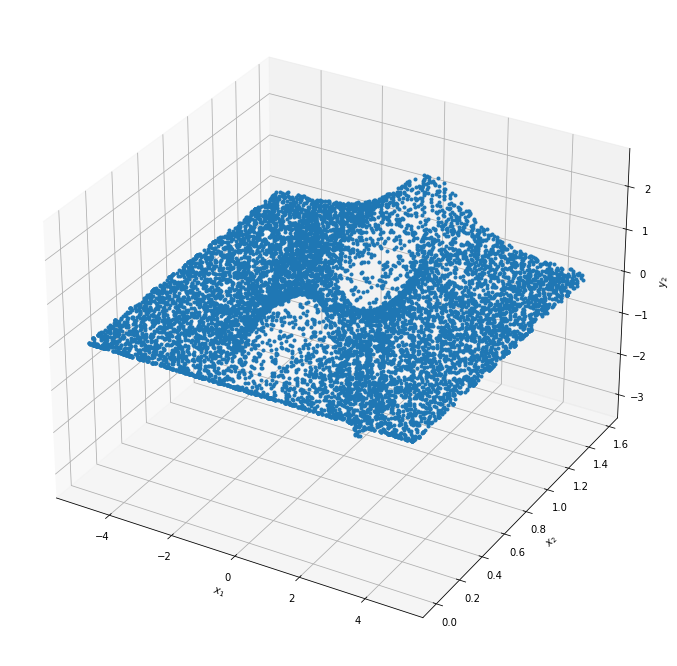

In [10]:
plot_best_state(train_state)

In [11]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)

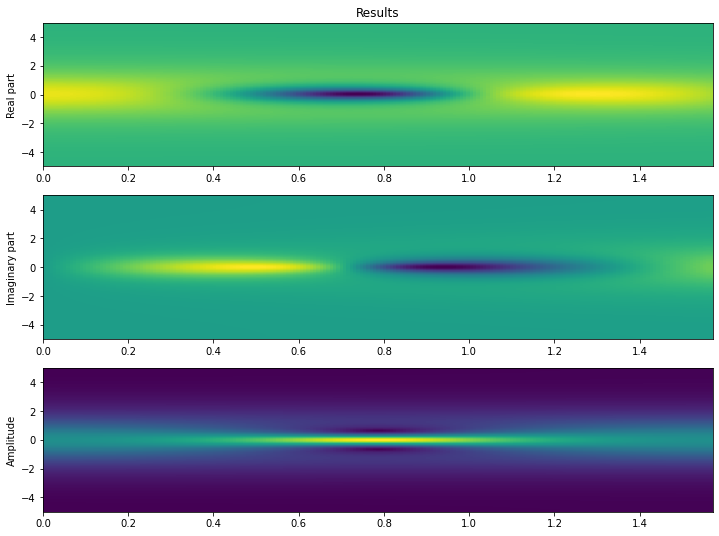

In [12]:
# Plot predictions
fig, ax = plt.subplots(3, figsize=(12,9))

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()

**评估准确性**

我们可以利用测试数据来评估训练好的模型的准确性.  
使用标准化的 $l^2 $norm 定义为  

Error $\large u = \frac{1}{||u_{test}||_{L^2}} ||u_{test} - u_{pred}||_{L^2}$  

其中 $u_{test}$是参考解，$u_{pred}$是模型给出的预测，我们得到:  

Error $u$: 1.854433e-03  
Error $v$: 2.413796e-03  
Error $h$: 1.426797e-03  

We can also plot the absolute value of the error for each point of the domain. It's everywhere in the order E-3.  
我们也可以绘制的绝对值的误差为每一点的领域。到处都是 E-3顺序的。

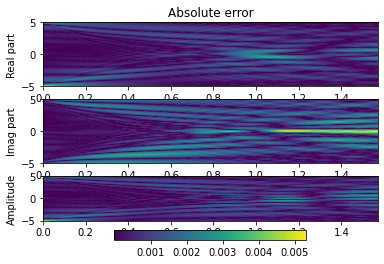

<a id="KdVEquation"></a>

## Korteweg–de Vries Equation
在数学中，Korteweg-De Vries (KdV) 方程是浅水表面波浪的数学模型。作为可精确解模型的典型示例，它尤其值得注意，即非线性偏微分方程的解可以精确且精确地指定。KdV 可以通过逆散射变换来求解。KdV 方程背后的数学理论是一个活跃的研究课题。KdV 方程首先由 Boussinesq（1877 年）引入，并由Diederik Korteweg和Gustav de Vries重新发现（1895 年）。



**科特韦赫-德弗里斯方程**（Korteweg-De Vries equation），一般简称**KdV方程**，是1895年由荷兰数学家科特韦赫和德弗里斯共同发现的一种偏微分方程。方程形式如下：
$$
\large u_t + u u_x + u_{xxx} = 0.
$$
关于实自变量 $x$ 和 $t$ 的函数 $φ$ 所满足的KdV方程形式如下：
$$
\large {\displaystyle \partial _{t}\phi -6\phi \partial _{x}\phi +\partial _{x}^{3}\phi =0};
$$
KdV方程的解为簇集的孤立子（又称孤子，孤波）。

KdV方程在物理学的许多领域都有应用，例如等离子体磁流波、离子声波、非谐振晶格振动、低温非线性晶格声子波包的热激发、液体气体混合物的压力表等。

### KdV 方程行波解

KdV 方程有多种孤波解。

- 钟形孤波解

$$
\large \phi(x,t)=\frac12\, c\, \mathrm{sech}^2\left[{\sqrt{c}\over 2}(x-c\,t-a)\right].
$$

- 扭形孤波解

$$
\large {\displaystyle \phi (x,t)=k\,\mathrm {tanh} [k(x+2tk^{2}+c)]}.
$$

- 暗孤波解

$$
\large \phi (x,t)=a+b\,\mathrm {tanh} (1+cx+dt)^{2}.
$$



https://zh.wikipedia.org/wiki/KdV%E6%96%B9%E7%A8%8B



#### 问题设置

我们的最后一个例子旨在强调所提出的框架处理涉及高阶导数的偏微分方程的能力。在这里，我们考虑在浅水表面上的波浪的数学模型：[Korteweg de Vries(KdV)方程](https://en.wikipedia.org/wiki/Korteweg–de_Vries_equation)。KdV方程如下所示：
$$
\large u_t + \lambda_1 uu_x + \lambda_2 u_{xxx} = 0,
$$
其中 $(λ_1,λ_2)$ 为未知参数。对于KdV方程，非线性算子由下式给出：
$$
\large \cal N[u^{n+c_j}] = \lambda_1 u^{n+c_j}u^{n+c_j}_x - \lambda_2 u^{n+c_j}_{xxx},
$$
通过最小化上述误差平方和，可以学习神经网络的共享参数以及KdV方程的参数 $λ = (λ_1,λ_2)$ 。



为了获得一组训练和测试数据，我们使用传统的谱方法模拟KdV方程。具体地说，从初始条件 $u (0，x) = \cos (πx)$ 出发，假设周期边界条件，我们用 Chebfun 程序包得到了KdV方程 ，最终时间 $t = 1.0$，该积分方程具有512个模式的谱离散化和时间步长 $\Delta t = 10^{-6}$的四阶显式 Runge-Kutta 积分器。利用这个数据集，我们提取了在时间 $t^n = 0.2$ 和 $t^{n + 1} = 0.8$ 时的两个解快照，然后用 $N_n = 199$和 $N_{n + 1} = 201$ 随机子样生成一个训练数据集。然后，我们利用这些数据使用 L-BFGS 训练一个离散时间物理信息神经网络最小化方程的平方误差损失之和。这种网络结构包括4个隐层，每层50个神经元，在 $q$ Runge-Kutta 阶段，即 $u^{n + c_j }(x) ，j = 1，... ，q$，其中 $q=0.5 \log \epsilon/ \log(\Delta t)$ 是通过设置 $\Delta t = 0.6$ 计算得到的。

下图总结了该实验的结果。

![img](https://maziarraissi.github.io/assets/img/KdV.png)

> *KdV方程*：**顶部**：解以及两个训练快照的时间位置。**中间**：与顶部面板中垂直虚线所示的两个时间快照相对应的训练数据和精确解。**底部**：修正偏微分方程和已识别的方程。


代码参考：

https://github.com/lululxvi/deepxde/issues/112

https://github.com/lululxvi/deepxde/blob/master/examples/pinn_inverse/diffusion_1d_inverse.py

https://github.com/maziarraissi/PINNs/blob/master/main/discrete_time_identification%20(KdV)/KdV.py

In [1]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



初值问题:

$$\begin{align}
& \large u_t + \lambda_1 uu_x + \lambda_2 u_{xxx} = 0, \lambda_1=1, \lambda_2=0.0025\\
& \large u(x, 0) = cos(\pi x), \\
& \large u(-1, t) = u(1, t), \\
& ----------------------\\
& \large u_x(-1, t) = u_x(1, t). \\
& \large u_{xxx}(-1, t) = u_{xxx}(1, t). \\
\end{align}$$


```mathematica
KdV = D[u[x, t], t] + 1/400*D[u[x, t], {x, 3}] + 
    u[x, t] D[u[x, t], x] == 0;
sol = DSolve[KdV, u[x, t], {x, t}]
```


```mathematica
KdVEquation = 
  D[u[x, t], t] + u[x, t] D[u[x, t], x] + 1/400*D[u[x, t], {x, 3}] == 0;
bc = {u[0, t] == u[1, t]};
ic = {u[x, 0] == Cos[Pi*x]};
sol = DSolve[{KdVEquation, bc, ic}, u[x, t], {x, t}]

KdVEquation = 
  D[u[x, t], t] + u[x, t] D[u[x, t], x] + 1/400*D[u[x, t], {x, 3}] == 0;
bc = {u[0, t] == u[1, t], 
   Derivative[1, 0][u][-1, t] == Derivative[1, 0][u][1, t], 
   Derivative[3, 0][u][-1, t] == Derivative[3, 0][u][1, t]};
ic = {u[x, 0] == Cos[Pi*x]};
sol = DSolve[{KdVEquation, bc, ic}, u[x, t], {x, t}]
```

具有狄利克雷边界条件和初始条件

$u(−1,t)=u(1,t)=0,u(x,0)=−sin(πx).$ 

In [2]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

lambda_1 = 1
lambda_2 = 0.0025

# def pde(x, y):
#     dy_t = dde.grad.jacobian(y, x, i=0, j=1)
#     dy_x = dde.grad.jacobian(y, x, i=0, j=0)
#     dy_xx = dde.grad.hessian(y, x, i=0, j=0)
#     dy_xxx = tf.gradients(dy_xx, x)[0][:, 0:1]
#     return dy_t + lambda_1*y*dy_x +  lambda_2*dy_xxx

def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_x, dy_t = dy_x[:, 0:1], dy_x[:, 1:]
    dy_xx = tf.gradients(dy_x, x)[0][:, 0:1]
    dy_xxx = tf.gradients(dy_xx, x)[0][:, 0:1]
    return dy_t + lambda_1*y*dy_x +  lambda_2*dy_xxx


bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: np.cos(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=8000, num_boundary=400, num_initial=800)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+8002=8002. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+802=802. 
  warnings.warn("The balance properties of Sobol' points require "


In [3]:
layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [4]:
model.compile("adam", lr=1e-3)
model.train(epochs=40000)

Compiling model...
Building feed-forward neural network...
'build' took 0.064750 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.985309 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.47e-03, 4.97e-02, 5.19e-01]    [7.47e-03, 4.97e-02, 5.19e-01]    []  
1000      [3.18e-02, 1.91e-02, 9.55e-02]    [3.18e-02, 1.91e-02, 9.55e-02]    []  
2000      [2.66e-02, 1.36e-02, 8.08e-02]    [2.66e-02, 1.36e-02, 8.08e-02]    []  
3000      [2.06e-02, 6.67e-03, 6.95e-02]    [2.06e-02, 6.67e-03, 6.95e-02]    []  
4000      [1.34e-02, 6.94e-03, 3.48e-02]    [1.34e-02, 6.94e-03, 3.48e-02]    []  
5000      [1.13e-02, 6.11e-03, 2.65e-02]    [1.13e-02, 6.11e-03, 2.65e-02]    []  
6000      [1.02e-02, 5.86e-03, 2.33e-02]    [1.02e-02, 5.86e-03, 2.33e-02]    []  
7000      [9.63e-03, 5.57e-03, 2.15e-02]    [9.63e-03, 5.57e-03, 2.15e-02]    []  
8000      [8.47e-03, 5.50e-03, 1.99e-02]    [8.47e-03, 5.50e-03, 1.99e-02]    []  
9000      [7.81e-03, 5.26e-03, 1.90e-02]    [7.81e-03, 5.26e-03, 1.90e-02]    []  
10000   

(<deepxde.model.LossHistory at 0x241aa0248e0>,
 <deepxde.model.TrainState at 0x241b6875640>)

In [5]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.600244 s

Training model...

Step      Train loss                        Test loss                         Test metric
40000     [2.98e-03, 3.71e-03, 7.34e-03]    [2.98e-03, 3.71e-03, 7.34e-03]    []  
41000     [1.75e-03, 3.14e-03, 3.40e-03]                                          
42000     [1.50e-03, 2.05e-03, 2.33e-03]                                          
43000     [1.16e-03, 1.42e-03, 2.19e-03]                                          
44000     [9.72e-04, 1.24e-03, 1.96e-03]                                          
45000     [8.11e-04, 1.06e-03, 1.84e-03]                                          
46000     [6.81e-04, 9.00e-04, 1.75e-03]                                          
47000     [6.39e-04, 7.33e-04, 1.63e-03]                                          
48000     [6.11e-04, 5.99e-04, 1.58e-03]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*

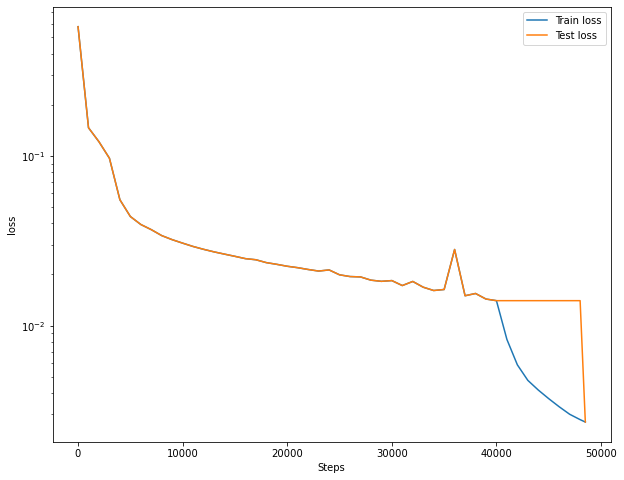

In [7]:
plot_loss_history(losshistory)

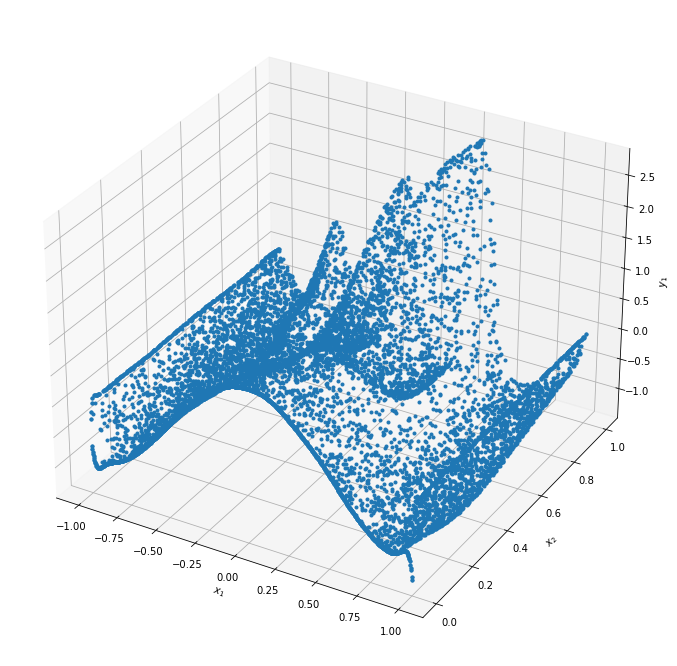

In [8]:
plot_best_state(train_state)

<a id="NavierStokesEquation"></a>

## Navier-Stokes方程

**NavierStokes求解需要的时间太长了,model.train需要几天，放弃了**

参考代码：
https://github.com/maziarraissi/PINNs/blob/master/main/continuous_time_identification%20(Navier-Stokes)/NavierStokes.py

### Navier-Stokes方程简介

流体力学：Navier-Stokes方程

纳维-斯托克斯方程是用于描述流体运动的方程，可以看作是流体运动的牛顿第二定律。

#### 可压缩的牛顿流体

对于可压缩的牛顿流体，可以得到
$$
\large \underbrace{\rho(\frac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u}) }_{惯性力} = \underbrace{-\nabla p}_{压力} + \underbrace{\nabla \cdot (\mu (\nabla \mathbf{u} + (\nabla \mathbf{u})^T) - \frac{2}{3}\mu (\nabla \cdot \mathbf{u})\mathbf{I})}_{黏性力} + \underbrace{\mathbf{F}}_{作用在流体上的外力}
$$
其中，$u$ 是流体速度，$p$ 是流体压力，$\rho$ 是流体密度，$\mu$ 是流体动力黏度。纳维-斯托克斯方程是由纳维、泊松、圣维南和斯托克斯于 1827 年到 1845 年之间推导出来的。这些方程总是要与连续性方程同时进行求解：
$$
\large \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{u}) = 0.
$$
纳维-斯托克斯方程表示动量守恒，而连续性方程则表示质量守恒。

#### 不可压缩流体

不可压缩流体的纳维－斯托克斯方程（Navier-Stoke equation）分为动量守恒公式
$$
\large \quad \overbrace {\rho {\Big (}\underbrace {\frac {\partial \mathbf {v} }{\partial t}} _{\begin{smallmatrix}{\text{非 稳 态}}\\{\text{加 速}}\end{smallmatrix}}+\underbrace {(\mathbf {v} \cdot \nabla )\mathbf {v} } _{\begin{smallmatrix}{\text{对 流}}\\{\text{加 速}}\end{smallmatrix}}{\Big )}} ^{\text{惯 性}}=\underbrace {-\nabla p} _{\begin{smallmatrix}{\text{压 强}}\\{\text{梯 度}}\end{smallmatrix}}+\underbrace {\mu \nabla ^{2}\mathbf {v} } _{\text{黏 滞 力}}+\underbrace {\mathbf {f} } _{\begin{smallmatrix}{\text{其 他 力}}\end{smallmatrix}}
$$
和质量守恒公式 $$\large \nabla\cdot\mathbf{v}=0.$$





纳维-斯托克斯方程的一般形式是：
$$
\large \rho\frac{\mathrm{D}\mathbf{v}}{\mathrm{D} t} = \nabla \cdot\mathbb{P} + \rho\mathbf{f}
$$
张量 $\mathbb {P}$ 代表施加在一个流体粒子上的表面力（应力张量）。

建立了流体的粒子动量的改变率（力）和作用在液体内部的压力的变化和耗散粘滞力（类似于摩擦力）以及重力之间的关系。

公式：

$$
\large \rho(\frac{\partial V}{\partial t} + V \cdot \nabla V) = \nabla P + \rho g + \mu \nabla^2 V.
$$
纳维尔－斯托克斯方程（Navier-Stokes equations），以法国工程师兼物理学家克劳德-路易·纳维、爱尔兰物理学和数学家乔治·斯托克斯两人命名，是一组偏微分方程，描述液体和空气等流体的运动。

纳维尔－斯托克斯方程表达了牛顿流体运动时，动量和质量守恒。有时，还连同状态方程列出，说明流体压强、温度、密度之间的关系。方程断言，流体粒子动量的改变率（力），来自作用在液体内部的压力变化、耗散粘滞力、以及重力。其中粘滞力类似于摩擦力，产生于分子的相互作用，越黏的流体，该作用就越强。这样，纳维-斯托克斯方程描述作用于液体任意给定区域的力的动态平衡。

学术研究和经济生活中，许多重要物理过程都可用纳维尔－斯托克斯方程描述，因此该些方程有很重要的研究价值。它们可以用于模拟天气、洋流、管道中的水流、星系中恒星的运动、翼型周围的气流，也可以用于设计飞行器和车辆、研究血液循环、设计电站、分析污染效应等等。纳－斯方桯组与马克士威方程组联立，用于研究磁流体力学。

纳维－斯托克斯方程依赖微分方程来描述流体的运动。不同于代数方程，这些方程不寻求建立所研究的变量（譬如速度和压力）的关系，而寻求建立这些量的变化率或通量之间的关系。用数学术语来讲，这些变化率对应于变量的导数。其中，在零粘滞度的最简单情况下，纳维-斯托克斯方程化为欧拉方程，表明加速度（速度的导数，或者说变化率）与内部压力的导数成正比。

这表示对于给定的物理问题，至少要用微积分才可以求得其纳维-斯托克斯方程的解。实用上，也只有最简单的情况才能用这种方法获得已知解。这些情况通常涉及稳定态（流场不随时间变化）的非紊流，其中流体的粘滞系数很大或者其速度很小（低雷诺数）。

对于更复杂的情形，例如厄尔尼诺这样的全球性气象系统或机翼的升力，现时仅能借助计算机求出纳维-斯托克斯方程的数值解。这个科学领域称为计算流体力学。

虽然紊流是日常经验中就可以遇到的，但这类非线性问题在理论上极难求解，仍未能证明三维空间中是否总存在光滑解，甚至有界解。此问题称为纳维-斯托克斯存在性与光滑性。克雷数学学院于2000年5月21日列入七大未解难题，悬赏一百万美元，奖励找到证明或反例的任何人。

